In [1]:
import numpy as np

# Preprocessing

In [2]:
data_read = []
with open('yearpredictionmsd/YearPredictionMSD.txt', 'r') as file:
    lines = file.readlines()
data_read = [line.strip().split(",") for line in lines]

In [3]:
# Validate that feature matches the specs
print("Total number of instance ", len(data_read))
print("Total number of features ", len(data_read[0][1:]))

Total number of instance  515345
Total number of features  90


### Checking for any missing attributes -> each instance should have 91 columns, index 0 matches year, index 1-90 matches features.

In [4]:
anomalies = []
for index, instance in enumerate(data_read):
    if (len(instance) != 91):
        anomalies.append(index)
print("No Anomalies detected: ", len(anomalies) == 0)

No Anomalies detected:  True


### Breakdown data into training and testing, first 463,715 to be training via data set instructions. Separate year with features, converting types.

In [5]:
training = np.array(data_read[:463715])
testing = np.array(data_read[463715:])

In [6]:
print(f"length of training {len(training)}, length of testing {len(testing)}, total {len(data_read)}")

length of training 463715, length of testing 51630, total 515345


In [7]:
def data_cleaning(data):
    years = data[:, 0]
    years = [int(year) for year in years]
    features = data[:, 1:]
    features = [np.double(feature) for feature in features]
    return np.array(years), np.array(features)


In [8]:
training_year, training_features = data_cleaning(training)
testing_year, testing_features = data_cleaning(testing)

### For Training Data, first normalize the attributes. 12 average timbre features / 78 timbre covariance features. Normalize each set first, then combine.

In [9]:
from sklearn.preprocessing import StandardScaler
training_avg = training_features[:,:12]
training_cov = training_features[:,12:]


training_scale_avg = StandardScaler()
training_scale_cov = StandardScaler()

training_avg_norm = training_scale_avg.fit_transform(training_avg)
training_cov_norm = training_scale_cov.fit_transform(training_cov)
training_features_norm = np.hstack((training_avg_norm, training_cov_norm))
print("Normalized feature shape: ", training_features_norm.shape)

Normalized feature shape:  (463715, 90)


# Data Analysis

In [10]:
import pandas as pd

training_features_columns = [f"timbre_feature_{i}" for i in range(training_features_norm.shape[1])]
training_df = pd.DataFrame(training_features_norm, columns=training_features_columns)
training_df['year'] = training_year
training_df.head()

,timbre_feature_0,timbre_feature_1,timbre_feature_2,timbre_feature_3,timbre_feature_4,timbre_feature_5,timbre_feature_6,timbre_feature_7,timbre_feature_8,timbre_feature_9,...,timbre_feature_81,timbre_feature_82,timbre_feature_83,timbre_feature_84,timbre_feature_85,timbre_feature_86,timbre_feature_87,timbre_feature_88,timbre_feature_89,year
0,1.078786,0.391566,1.826962,0.466361,-0.476621,-0.275266,-1.551924,-1.311105,0.389093,-0.665402,...,0.106413,0.144257,-0.236180,0.047430,-0.355855,0.544084,-0.470477,-0.255366,0.042637,2001
1,0.879511,0.332631,1.748961,0.723345,-0.166769,-1.189729,0.764797,0.109714,1.422683,0.416934,...,0.304413,-0.068758,0.053729,-0.634467,-0.435794,0.556059,0.570861,0.209341,1.161118,2001
2,1.245515,0.592771,1.337550,0.752153,-0.002899,-0.699856,-0.061323,-0.069912,1.167910,-0.073176,...,0.565220,-0.758259,-0.282931,-0.026058,0.223918,-0.508889,-0.338081,0.107828,-0.090122,2001
3,0.799787,-0.061214,0.784000,0.089197,0.327463,-1.297159,0.509977,-1.073557,-0.015553,-1.262565,...,-0.562444,-0.479423,-0.890199,-0.796124,0.568335,-0.262505,0.409924,0.973205,0.795200,2001
4,1.247663,0.793377,1.657449,0.449177,-0.408652,-0.564673,-0.692545,-0.952369,0.843389,-0.143557,...,0.097564,0.192974,-0.585048,-0.113758,-0.219524,0.448546,0.258400,0.194381,1.244057,2001


### Plot a heatmap of feature correlation matrix to see which features are correlated with another. Also plot to see if there is a strong single feature correlated with the year.

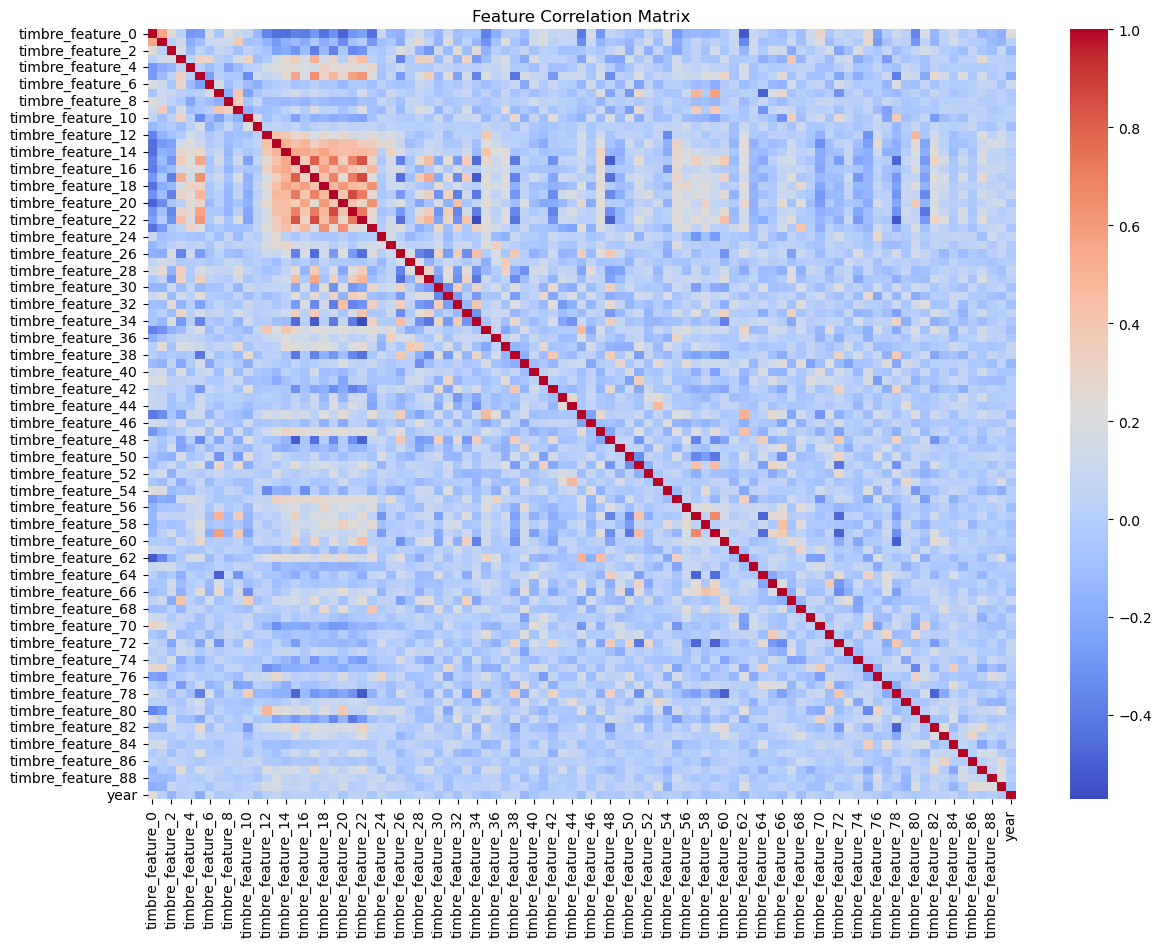

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix (features + year)
corr_matrix = training_df.corr()

# Heatmap of correlation
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

### Plot a class distribution of year as label in training data to see any imbalance of data.

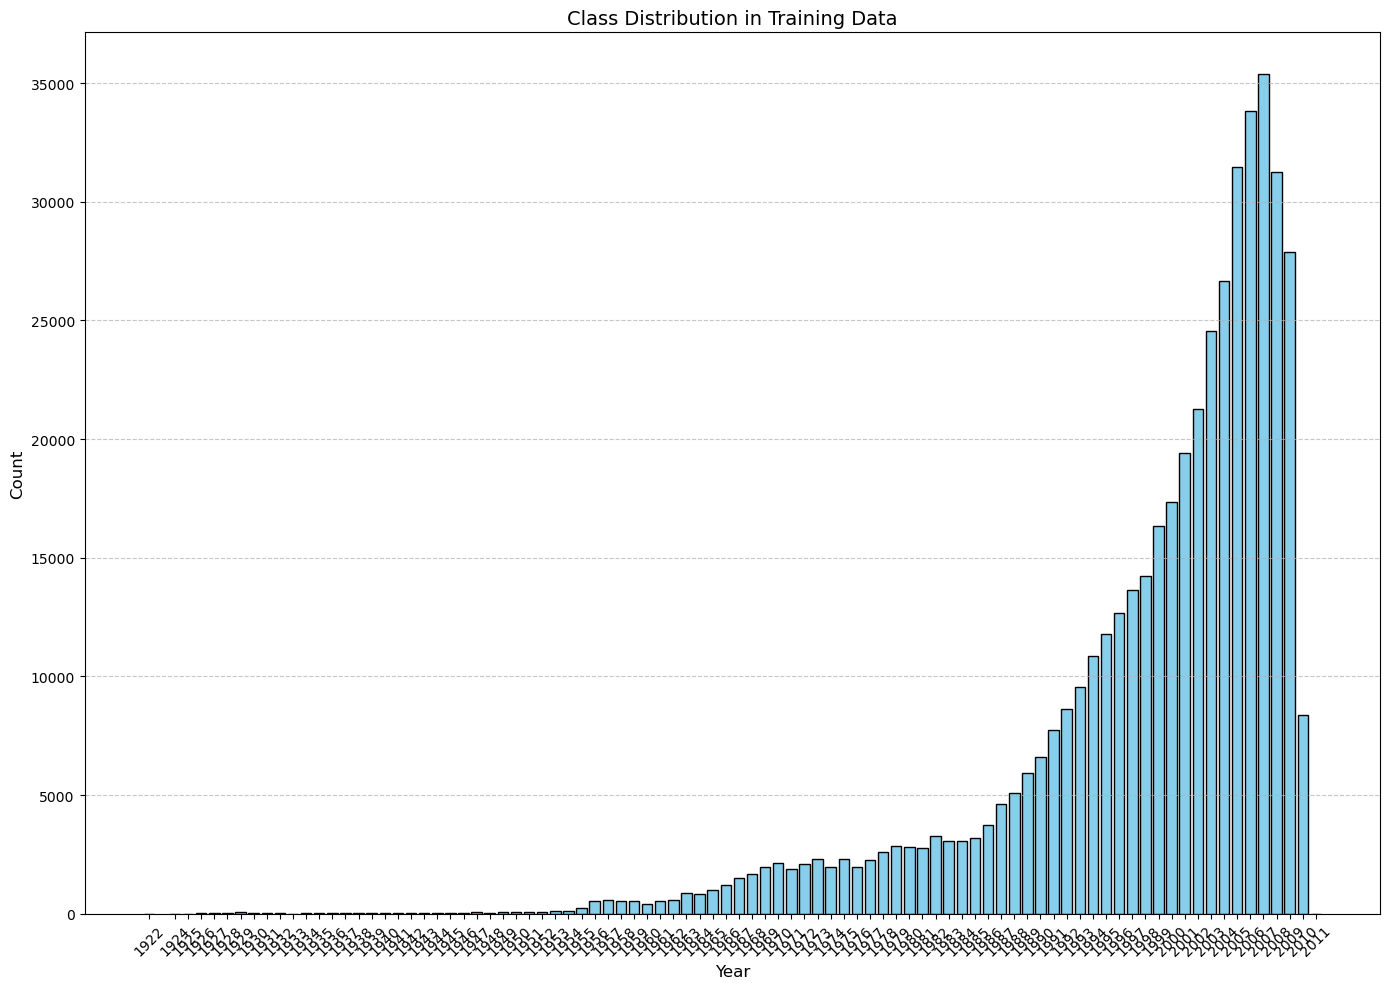

In [12]:
# Calculate unique values and their counts
unique, counts = np.unique(training_year, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(14, 10))
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.title('Class Distribution in Training Data', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(unique, rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Regression Models

### Training Regression models on training data and checking R^2 score on the training data. Separated into sections of computation intensive models.

### Lightweight Models Start ------------------------------------------------------------------------------------------------------------------------

In [13]:
import time

In [15]:
# Linear Regression
from sklearn.linear_model import LinearRegression
start_time = time.time()


model_linreg = LinearRegression()
model_linreg.fit(training_features_norm, training_year)

end_time = time.time()
elapsed_time = end_time - start_time
print("Linear Regression R^2: ", model_linreg.score(training_features_norm, training_year))
print(f"Completed in {elapsed_time:.2f} seconds.")

Linear Regression R^2:  0.2374852391376685
Completed in 6.80 seconds.


In [16]:
# Poisson Regression
from sklearn.linear_model import PoissonRegressor
start_time = time.time()

model_poissonreg = PoissonRegressor()
model_poissonreg.fit(training_features_norm, training_year)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Completed in {elapsed_time:.2f} seconds.")
print("Poisson Regressor R^2 ", model_poissonreg.score(training_features_norm, training_year))


Completed in 4.46 seconds.
Poisson Regressor R^2  0.2368289594634171


In [17]:
# Ridge
from sklearn.linear_model import Ridge
start_time = time.time()

model_Ridge = Ridge()
model_Ridge.fit(training_features_norm, training_year)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Completed in {elapsed_time:.2f} seconds.")
print("Ridge R^2 ", model_Ridge.score(training_features_norm, training_year))

Completed in 2.82 seconds.
Ridge R^2  0.23748523912708663


### Lightweight Models End ------------------------------------------------------------------------------------------------------------------------

### Warning: Computation Intensive Models -------------------------------------------------------------------------------------------------

In [19]:
# Neural Network
# WARNING: HEAVY COMPUTATION LOAD ~ 15mins
from sklearn.neural_network import MLPRegressor
start_time = time.time()

model_MLP = MLPRegressor(tol=0.005, random_state=0)
model_MLP.fit(training_features_norm, training_year)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Completed in {elapsed_time:.2f} seconds.")
print("Perceptron R^2 ", model_MLP.score(training_features_norm, training_year))

Completed in 801.27 seconds.
Perceptron R^2  0.3228571943070082


In [18]:
from sklearn.ensemble import RandomForestRegressor
start_time = time.time()

model_RFR = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50)
model_RFR.fit(training_features_norm, training_year)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Completed in {elapsed_time:.2f} seconds.")
print("Random Forest Regressor R^2 ", model_RFR.score(training_features_norm, training_year))

Completed in 249.77 seconds.
Random Forest Regressor R^2  0.2446730625112834


In [ ]:
# SVR (Support Vector Regression)
# WARNING: HEAVY COMPUTATION LOAD ~ 15 Mins
from sklearn.svm import LinearSVR
start_time = time.time()

model_SVR = LinearSVR(tol=0.005) 
model_SVR.fit(training_features_norm, training_year)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Completed in {elapsed_time:.2f} seconds.")
print("SVR R^2 ", model_SVR.score(training_features_norm, training_year))

### Computation Intesive Models End ----------------------------------------------------------------------------------------------------------

# Data Prediction

### Convert testing data to the same format as training.

In [20]:
testing_avg = testing_features[:,:12]
testing_cov = testing_features[:,12:]


testing_scale_avg = StandardScaler()
testing_scale_cov = StandardScaler()

testing_avg_norm = testing_scale_avg.fit_transform(testing_avg)
testing_cov_norm = testing_scale_cov.fit_transform(testing_cov)
testing_features_norm = np.hstack((testing_avg_norm, testing_cov_norm))
print("Normalized feature shape: ", testing_features_norm.shape)

Normalized feature shape:  (51630, 90)


In [21]:
# Linear Regression
model_linreg.score(testing_features_norm, testing_year)

0.23159070123852654

In [27]:
# Poisson Regression
model_poissonreg.score(testing_features_norm, testing_year)

0.2309268079402953

In [25]:
# Ridge Regression
model_Ridge.score(testing_features_norm, testing_year)

0.23159069379688357

In [29]:
# MLP Regression Neural Network
model_MLP.score(testing_features_norm, testing_year)
results = model_MLP.predict(testing_features_norm)

2007